# Visualizing multivariate, spatio-temporal information in the Cloud: 
## the climate response to volcanic eruptions

_Tech Objective:_ Build a dashboard of spatio-temporal plots that can be explored using interactive GUI elements. 

Tech skills:
- Processing analysis-ready, cloud-optimized data with Xarray
- Building a dashboard to visualize several climate variables at once
- Integrating widgets to facilitate rebuilding a figure without modifying code

_Scientific Context:_ A common need of climate scientists is to diagnose the response of the climate system to external influences. For example, an instance of explosive volcanism introduces sunlight-reflecting particles in the stratosphere, thereby cooling climate in the years that follow a large eruption. In this notebook, we use the Last Millennium Reanalysis and the evolv2k dataset to probe the this relationship over the Common Era.  

Per usual, first we'll load packages we will need.

In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
from pathlib import Path
import numpy as np
import cftime
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import ipywidgets as widgets


### Data
We'll load two datasets using Xarray.

- **Last Millenium Reanalysis Project (LMR)**: The gridded output from the Last Millenium Reanalysis Project is (happily) available via Pangeo-Forge. 

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Hakim, G. J., Emile-Geay, J., Steig, E. J., Noone, D., Anderson, D. M., Tardif, R., Steiger, N., and Perkins, W. A. (2016), The last millennium climate reanalysis project: Framework and first results, J. Geophys. Res. Atmos., 121, 6745– 6764, doi:10.1002/2016JD024751.|
| Tardif, R., Hakim, G. J., Perkins, W. A., Horlick, K. A., Erb, M. P., Emile-Geay, J., Anderson, D. M., Steig, E. J., and Noone, D.: Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling, Clim. Past, 15, 1251–1273,  https://doi.org/10.5194/cp-15-1251-2019 , 2019. |

- **Variation in Stratospheric Aerosol Optical Depth**: Data about variation in SAOD due to volcanic eruptions is a available [here]() and is loaded directly from the file.

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|Toohey, M. and Sigl, M.: Volcanic stratospheric sulfur injections and aerosol optical depth from 500 BCE to 1900 CE, Earth Syst. Sci. Data, 9, 809–831, https://doi.org/10.5194/essd-9-809-2017, 2017.|


##### _[Pangeo-Forge](https://pangeo-forge.org/):_ 
Briefly, Pangeo-Forge is a project that makes it easy to access large datasets (often stored in many parts) via a url, and work with them without having to maintain local copies of the data--good for the hard drive, good for the RAM!. For more information about Pangeo-Forge, check out [this notebook](), and for the intrepid reader looking for a deeper dive, their much more nuanced tutorials might be just the ticket.

##### _[Xarray](https://xarray.dev/):_
Xarray is specifically designed to accomodate multidimensional data, like that from a NetCDF file, or in this case a zarr file (another multidimensional data file type that is somewhat slimmer). Here we'll look at a few functionalities of Xarray, but for more information about wrangling seemingly unweildy datasets, check out [this primer on widgets](https://github.com/jordanplanders/PaleoBooks_dev/blob/6fe2427b743f82961076db3ab38951c7fe7b55ea/notebooks/primer_widgets.ipynb). 


### LMR


This LMR data set contains output for 20 Monte Carlo simulations (`MCrun`) run on a 2x2 degree latitude-longitude grid. Monte Carlo simulations are a useful way of acknowledging that we don't know exactly how climate evolved, but the group characteristics of multiple possible trajectories are more likely to capture the underlying story. 

In [2]:
# Load data using Pangeo-Forge
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1200/LMRv2p1_MCruns_ensemble_gridded.zarr"
lmr_ds_gridded = xr.open_dataset(store, engine='zarr', chunks={})
lmr_ds_gridded

,Array,Chunk
Bytes,2.44 GiB,1.25 MiB
Shape,"(2001, 20, 91, 180)","(1, 20, 91, 180)"
Count,2002 Tasks,2001 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.44 GiB,1.25 MiB
Shape,"(2001, 20, 91, 180)","(1, 20, 91, 180)"
Count,2002 Tasks,2001 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


That said, sometimes it is appropriate to work with summary statistics (like the mean). In the cell below, we pass `dim='MCrun'` to `mean()` to tell xarray to take the mean over `MCrun` while respecting time, latitude, and longitude.

In [3]:
# take the mean of all MC runs at each lat-lon point at each time
lmr_ds_gridded_mean = lmr_ds_gridded.mean(dim='MCrun')

It is not uncommon for one set of units to be optimal one calculation, but far less so for another. Below we'll make variables for precipitation rate in mm/day, time in years and latitude in radians following the form:
```
ds.assign(new_var_name = new_var_value)
```
*This is pretty much as one would expect except `new_var_name` will become the name of the variable (usually done with a string assignment) while here is assigned values in the style of a variable assignment. [There's a decent chance that if this footnote seemed obscure, you are unlikely to make the mistake it is addressing, so proceed with confidence!]*

In [4]:
# convert prate_mean from kg/(m^2*s) to mm/day
prate_unit_conversion = 86400
lmr_ds_gridded_mean=lmr_ds_gridded_mean.assign(prate_m=lmr_ds_gridded_mean['prate_mean'] * prate_unit_conversion)

In [5]:
# create a variable for year
lmr_ds_gridded_mean = lmr_ds_gridded_mean.assign(year=lmr_ds_gridded_mean['time'].dt.year)

In [6]:
# create a variable for latitude in radians
lmr_ds_gridded_mean= lmr_ds_gridded_mean.assign(lat_rad=np.deg2rad(lmr_ds_gridded_mean['lat']))

#### Global Snapshots in time 
The final goal of this notebook is to compose a dashboard of useful visualiations that might help us explore our data. Given evidence that volcanic emissions affect cloud formation and surface temperature, surface air temperature and daily precipitation seem like good candidates. 

_Contour Map Elements_
1. Figure with a defined `projection` (map projection); add features (e.g. coastlines)
2. `add_cyclic_point`, putting data on a coordinate system that renders continuously between lon=360 and lon=0
3. Plot contour or contourf with `lonc`, lat, and data processed by the cyclic transform
4. Colorbar

In [7]:
snapshot_data = lmr_ds_gridded_mean.isel(time=(lmr_ds_gridded_mean.time.dt.year == 916))

##### Surface Air Temperature

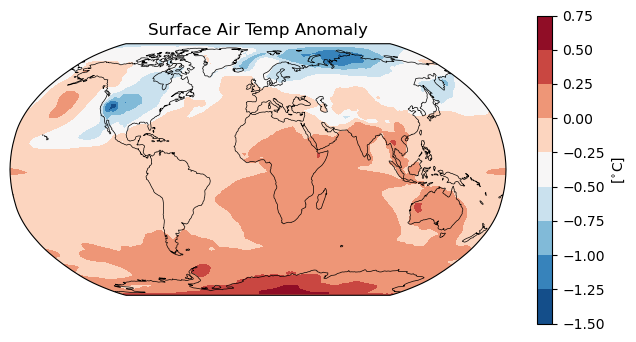

In [8]:
fig = plt.figure(figsize=(8, 4))

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(snapshot_data['air_mean'], snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,snapshot_data['lat'],tas_c.squeeze(), cmap='RdBu_r',
                   transform=ccrs.PlateCarree())

# add annotations (colorbar, title)
plt.colorbar(cf2, label='[$^{\circ}$C]')
ax2.set_title('Surface Air Temp Anomaly');

Not bad, but if we want to place this in a dashboard with other plots, it would help to have a colorbar that behaves predictably. One way to do that is to make a separate axis for a colorbar and then construct the colorbar from the contour information directly, rather than having matplotlib produce it as an afterthought. One of the ways matplotlib places colorbars is by allowing them to share a fraction of the plotting axis. This isn't particularly concerning when there is only one plot in the mix, but can become less tidy when there are multiple plots, each with a colorbar that requires a different amount of space for labelling, etc. 

Enter: `GridSpec`. The gridspec functionality in matplotlib improves the odds that objects of interest will reside in their assigned slots in a grid. Broadly, a grid includes information about the number of rows and columns, and optionally, about the size of each margin(`top`, `bottom`, `left`, `right`), the space between columns (`wspace`) or rows (`hspace`), and the relative sizes of rows `width_ratios` and columns (`height_ratios`).

Text(0.5, 1.0, 'Surface Air Temp Anomaly')

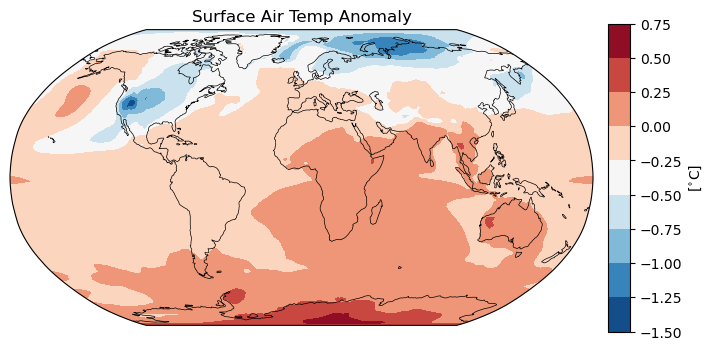

In [9]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 6:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(snapshot_data['air_mean'], snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,snapshot_data['lat'],tas_c.squeeze(), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r')

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(cf2, cax = ax2_cb, orientation='vertical',label='[$^{\circ}$C]')
ax2.set_title('Surface Air Temp Anomaly')


That's an improvement. It would be possible to fiddle with the various knobs to arrive at whatever spacing seemed most comfortable, but this will suffice for the time being. 

However, if we want to quickly visually compare plots that communicate most of their information via color, we might be better served by explicilty defining and then mandating a colorbar that will span the full range of values under consideration rather than have the colorbar change with every plot. 

In the final version of this plot the colorbar is constructed by building a scale with 15 levels ranging between plus and minus the maximum amplitude. (For example, if the lowest temperature is -1.5, and the highest is .5, the scale will go from -1.5 to 1.5 with 15 levels. Symmetry around 0 can make it easier to interpret this kind of data.) The contourf function requires information about the range of values, the color map, and how values are distributed across that color map. Collectively, this information is a `ScalarMappable`. Because we'll want to do this again later on, let's write a funcfion to do the task. 

In [10]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if n is None:
        ax_cmap = plt.get_cmap(cmap)
    else:    
        ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [11]:
nc = 21

Text(0.5, 1.0, 'Surface Air Temp Anomaly')

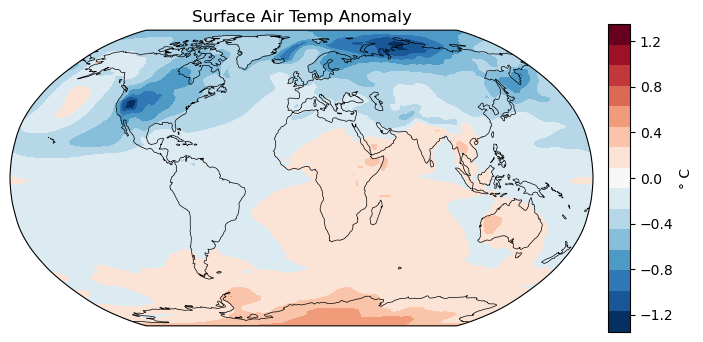

In [12]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# establish scale
ax2_Li_1 = max([np.abs(snapshot_data['air_mean'].max().compute()), 
                np.abs(snapshot_data['air_mean'].min().compute())])
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
# make scalar mappable
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(snapshot_data['air_mean'], snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,snapshot_data['lat'],tas_c.squeeze(),nc, levels=ax2_levels, 
                   transform=ccrs.PlateCarree(), **cf2_kwargs)

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label="\xb0 C", 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     

ax2.set_title('Surface Air Temp Anomaly')


##### Surface Temp Anomaly & Daily Precipitation

Text(0.5, 1.0, 'Daily Precipitation')

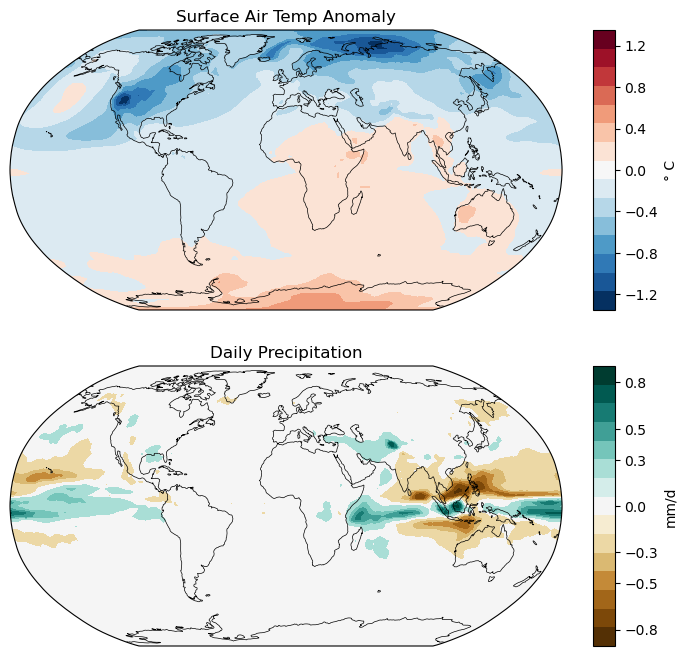

In [13]:
fig = plt.figure(figsize=(8, 8))
# 1 row, 2 columns, .05 space between columns, 6:.3 ratio of left column to right column
gs = gridspec.GridSpec(2, 2,hspace=.2, wspace=0.05, width_ratios=[8, .3], height_ratios=[1,1])

# SURFACE TEMP
# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# establish scale
ax2_Li_1 = max([np.abs(snapshot_data['air_mean'].max().compute()), 
                np.abs(snapshot_data['air_mean'].min().compute())])
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
# make scalar mappable
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(snapshot_data['air_mean'], snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,snapshot_data['lat'],tas_c.squeeze(),nc, levels=ax2_levels, 
                   transform=ccrs.PlateCarree(), **cf2_kwargs)

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label="\xb0 C", 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     

ax2.set_title('Surface Air Temp Anomaly')



# DAILY PRECIPITATION
# add subplot with specified map projection and coastlines (GeoAxes)
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson(central_longitude=0))
ax3.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# establish scale
ax3_Li_1 = max([np.abs(snapshot_data['prate_m'].max().compute()), 
                np.abs(snapshot_data['prate_m'].min().compute())])
ax3_levels = np.around(np.linspace(-ax3_Li_1, ax3_Li_1, 15), decimals=1)
# make scalar mappable
ax3_sm = make_scalar_mappable([ax3_Li_1, -ax3_Li_1], 'BrBG', 15)
cf3_kwargs = {'cmap':ax3_sm.cmap, 'norm' : ax3_sm.norm}

# place data on coordinate system with continuous x axis (longitude axis)
prate_c, lonc = cutil.add_cyclic_point(snapshot_data['prate_m'], snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf3 = ax3.contourf(lonc,snapshot_data['lat'],prate_c.squeeze(),nc, levels=ax3_levels, 
                   transform=ccrs.PlateCarree(), **cf3_kwargs)

# add annotations (colorbar, title)
ax3_cb = fig.add_subplot(gs[1, 1])
cb3 = plt.colorbar(ax3_sm, cax=ax3_cb, orientation='vertical',label="mm/d", 
                   ticks=[loc for ik, loc in enumerate(ax3_levels) if ik%2>0])
cb3.minorticks_off()                     

ax3.set_title('Daily Precipitation')

Now then, that's looking quite pleasing!

### Optical properties of volcanic aerosols
Here we will use the eVolv2k EVA AOD data [Toohey and Sigl, 2017]. These data have dimensions of latitude (degrees north) and time (fractional years), which warrants investigation in continuous space, but also we will eventually want to convert to a global yearly average. Excellent! A teachable moment awaits! [First, we'll load some data using Xarray.]

In [14]:
vol_data = 'eVolv2k_v3_EVA_AOD_-500_1900_1.nc'
vol_ds = xr.open_dataset(Path(os.getcwd()).parent/'data'/vol_data)

In the same vein as the global snapshots, let's add latitude in radians to our dataset.

In [15]:
vol_ds = vol_ds.assign(lat_rad=np.deg2rad(vol_ds.lat))
vol_ds = vol_ds.set_coords(['lat_rad'])
vol_ds

<xarray.Dataset>
Dimensions:  (time: 28812, lat: 96)
Coordinates:
  * time     (time) float32 -500.0 -499.9 -499.8 ... 1.901e+03 1.901e+03
  * lat      (lat) float32 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
    lat_rad  (lat) float32 1.546 1.514 1.481 1.449 ... -1.481 -1.514 -1.546
Data variables:
    aod550   (time, lat) float32 ...
    reff     (time, lat) float32 ...
Attributes:
    title:                         EVA v1.2: stratospheric AOD
    EVA_reference:                 Toohey, M., Stevens, B., Schmidt, H., and ...
    EVA_source_code:               https://github.com/matthew2e/easy-volcanic...
    input_vssi_file:               eVolv2k_v3_ds_1.nc
    input_sulfate_parameter_file:  EVAv1_parameter_set_piBG.nc
    input_forcing_parameter_file:  EVAv1_parameter_set_piBG.nc
    input_grid_file:               eva_gridfile_echam_T63_sw.nc
    input_Mie_file:                eva_Mie_lookuptables.nc
    history:                       Created on 15.07.2019 at 14:29:58

#### `pcolor` plot
We don't have latitude-longitude pairs for `aod550` data, but given atmospheric mixing across latitude bands, it may be informative to plot variation in the stratospheric aerosol optical at a wavelength of 550 nm on a time-latitude grid. `pcolor`, or pseudocolor plots are useful for visualizing three dimensions of data, in 2D.  When the data has two independent variables (like latitude and time) and one dependent variable, one option is to plot it in a three axis x-y-z arrangement, but interpretting 2D renderings of 3D objects is tricky, so often it is easier to investigate data presented as a variation in color over the grid formed by, for example, time and latitude. 

##### Components
This plot depends on figure, so we'll want to apply our colorbar approach from the prior plots, from the get-go. Thus, we need:
- figure + gridspec (with slots for the figure and colorbar)
- a scalar mappable (generated with `make_scalar_mappable()`)
- meshgrid
- pcolor

Somewhat similarly to how we constructed an appropriate coordinate system for the filled contour plots using the cyclic_point, we can pass two vectors to `np.meshgrid()` to create the components of grid that underpins our `pcolor` plot. Then, also like the filled contour plots, all we need to do is pass the grid components, a matrix of values, and information about the color scheme to `ax.pcolor()`, and we'll be on our way!

In [16]:
# consider a window around a year of interest
before, after = 2, 5
erup_yr=940

itmp_slice = vol_ds.sel({'time':slice(erup_yr-before, erup_yr+after)})

If we wanted the coloring to be scaled to the data in this specific interval, we could use local minimum and maximum values:

In [17]:
# interval specific color scale
vol_vlims = [itmp_slice.aod550.min().values.ravel()[0], itmp_slice.aod550.max().values.ravel()[0]]
ax0_sm = make_scalar_mappable(vol_vlims, 'magma')

However, If we wanted this figure to maintain the same colorscale regardless of the `erup_yr`, we could use the mininum and maximum values of all the SAOD variation data to calculate our `scalar_mappable`.  

In [18]:
# general color scale
vol_vlims = [vol_ds.aod550.min().values.ravel()[0], vol_ds.aod550.max().values.ravel()[0]]
ax0_sm = make_scalar_mappable(vol_vlims, 'magma')

Now we'll use `np.meshgrid()` to construct a time-latitude (in radians) grid.  

In [19]:
t, l = np.meshgrid(itmp_slice.time,itmp_slice.lat_rad)

/var/folders/8f/31mjs7t50z73h7x1sf90w8040000gn/T/ipykernel_56167/3920750907.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set(**ax0_axformatting_d)


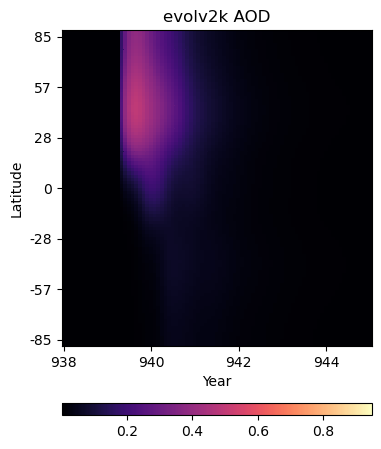

In [20]:
fig = plt.figure(figsize=(4, 5))
# 2 rows, 1 column, .05 space between rows, 8:.3 ratio of top row to bottom row
gs = gridspec.GridSpec(2, 1, hspace=0.35, height_ratios=[8, .3])
    
# evolv2k AOD
ax0 = fig.add_subplot(gs[0, 0])
pc = ax0.pcolor(t, l,itmp_slice.aod550.data.T, cmap=ax0_sm.cmap, norm=ax0_sm.norm)
# write ticks in degrees
tick_deg = [int(np.rad2deg(tick)) for tick in ax0.get_yticks()]
ax0_axformatting_d = {'ylabel':'Latitude', 
                      'yticklabels':map(str, tick_deg), 
                    'xlabel':'Year'}
ax0.set(**ax0_axformatting_d)
ax0.set_title(r'evolv2k AOD')

# colorbar
ax0c = fig.add_subplot(gs[1, 0])
ax0_cb = plt.colorbar(ax0_sm, cax=ax0c, orientation='horizontal')

#### Global average SAOD550 variation timeseries
In conjunction with a pcolor plot, it can be useful to look at the evolution of a summary statistic like the global mean. The `time` dimension of this dataset is different from that in the LMR data. The attributes say that it is in "fractional year (ISO 8601, including year 0)", which, with a little inspection, we see means that there are 12 values per year (monthly) reported at the beginning of each month. Our goal is to bring this data onto the same timescale as the LMR data (yearly), and the easiest way to do this will be to group by year, and take the mean. 

_Side note: The study of history goes from 1BCE to 1CE without hesitation, but this poses some challenges mathematically with timeseries. Thus, we'll stick to the standard astronomical calendar._

In [21]:
vol_ds.time

<xarray.DataArray 'time' (time: 28812)>
array([-500.     , -499.91666, -499.83334, ..., 1900.75   , 1900.8334 ,
       1900.9166 ], dtype=float32)
Coordinates:
  * time     (time) float32 -500.0 -499.9 -499.8 ... 1.901e+03 1.901e+03
Attributes:
    long_name:  fractional year (ISO 8601, including year 0)
    units:      year

At the time of writing this, there are inevitably multiple ways to do this, and likely more by the time of reading this, but one option is to add a tiny fraction of a month to the time vector such that every entry for a given year--including the first entry--shares the same whole number component (-499.w, -499.y...etc. rather than -500.0, -499.x, -499.z...etc.), and then convert those values to integers. 

*_Without that small addition the values for the first year would be: (-500, -499, -499, ...-499),
with that small addition they become: (-499, -499, -499...-499), making it easy to apply `groupby('year').mean()`_

We could use `assign()` like this, 

In [22]:
vol_ds.assign(year = np.add(vol_ds.time.data, 1/24).astype(int))
# note: if we don't say vol_ds = vol_ds.assign... the change won't be saved

<xarray.Dataset>
Dimensions:  (time: 28812, lat: 96, year: 28812)
Coordinates:
  * time     (time) float32 -500.0 -499.9 -499.8 ... 1.901e+03 1.901e+03
  * lat      (lat) float32 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
    lat_rad  (lat) float32 1.546 1.514 1.481 1.449 ... -1.481 -1.514 -1.546
  * year     (year) int64 -499 -499 -499 -499 -499 ... 1900 1900 1900 1900 1900
Data variables:
    aod550   (time, lat) float32 0.00246 0.002468 0.002483 ... 0.00246 0.002452
    reff     (time, lat) float32 ...
Attributes:
    title:                         EVA v1.2: stratospheric AOD
    EVA_reference:                 Toohey, M., Stevens, B., Schmidt, H., and ...
    EVA_source_code:               https://github.com/matthew2e/easy-volcanic...
    input_vssi_file:               eVolv2k_v3_ds_1.nc
    input_sulfate_parameter_file:  EVAv1_parameter_set_piBG.nc
    input_forcing_parameter_file:  EVAv1_parameter_set_piBG.nc
    input_grid_file:               eva_gridfile_echam_T63_sw.nc
    input_Mie_file:                eva_Mie_lookuptables.nc
    history:                       Created on 15.07.2019 at 14:29:58

but in the longer run, it's actually handy to add `year` as a data variable of the `time` dimension. 

In [23]:
vol_ds['year'] = (('time'), np.add(vol_ds.time.data, 1/24).astype(int))

#### Weighted Means in Xarray
Sometimes it is practical to apply weights before doing a calculation. In addition to the many project-specific adjustments that exist, there are common instances in which we use bins--for example, a grid cell, or a month--that may each constitute an item on a list with equal weight in the eyes of a mathematical operator, but which as a practical matter should have different levels of influence on aggregate values. 

It may be tempting to simply apply `.mean()`, taking the average of all data for a given timestep, but not all grid cells cover the same area! (Indeed, the area of grid cells shrinks to 0 as one approaches the poles.) Happily, we can take advantage of one of Xarray's built in functions, `weighted` to correct for this and give the earth's curvature its due. 

- The `lat` coordinate is in degrees North, so we'll use Numpy, a core Python scientific computing package, to convert to radians and then take the cosine to arrive at a vector of latitude weights (weights).
- `weights` is a transformed version of `lat` so Xarray infers that it should be applied along the `lat` coordinate.

In [24]:
vol_ds_weighted = vol_ds.copy()

In [25]:
lat_weights = np.cos(vol_ds_weighted.lat_rad)
lat_weights.name = "lat_weights"

vol_ds_weighted['weighted_aod550'] = (('time', 'lat'), (vol_ds_weighted['aod550']*lat_weights).data)
vol_ds_weighted = vol_ds_weighted.set_coords(['year'])

We can finally use `groupby('year').mean().mean(dim='lat')` to first calculate the weights-applied latitude-wise yearly average, and then calculate the global yearly average.

In [26]:
vol_ds_year_wm = vol_ds_weighted.groupby('year').mean().mean(dim='lat')
vol_ds_year_wm

<xarray.Dataset>
Dimensions:          (year: 2400)
Coordinates:
  * year             (year) int64 -499 -498 -497 -496 ... 1897 1898 1899 1900
Data variables:
    aod550           (year) float32 0.002833 0.002861 ... 0.002903 0.002903
    reff             (year) float32 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    weighted_aod550  (year) float32 0.001826 0.001836 ... 0.001863 0.001863

Let's put the `pcolor` plot above in a grid with the corresponding time segment of the global average timeseries. There are only two new plotting notes:
1. the `gridspec` has four slots to accommodate the pcolor plot and its colorbar, the timeseries, and an empty slot to act as a buffer between the colorbar and the timeseries
2. `ax1.sharex(ax0)` ensures that the two plots will share the same x-axis

In [27]:
itmp_slice_yr = vol_ds_year_wm.sel(year=slice(int(erup_yr)-before, int(erup_yr)+after))

In the same category as applying latitude-based weights to calculate a more accurate global average, let's revisit the spacing of the latitude axis of our SAOD (lat, time) Hovmüller diagram (our pcolor plot). By using sin(lat) as the y coordinate on a plot like this, the actual area of the globe covered by a given latitude band is preserved, allowing us to "integrate by eye" and better gauge the contribution of each latitude band to the total.

We'll stow these new tick locations, and tick labels in degrees north, along with other axis information a dictionary to efficiently update the axes.

In [28]:
tick_lat = np.arange(-80,100,20)
sin_ticks = np.sin(tick_lat*np.pi/180)

ax0_axformatting_d = {'ylabel':'Latitude', 
                       'ylim':[min(sin_ticks), max(sin_ticks)], 
                       'yticks':sin_ticks, 'yticklabels':map(str, tick_lat)}

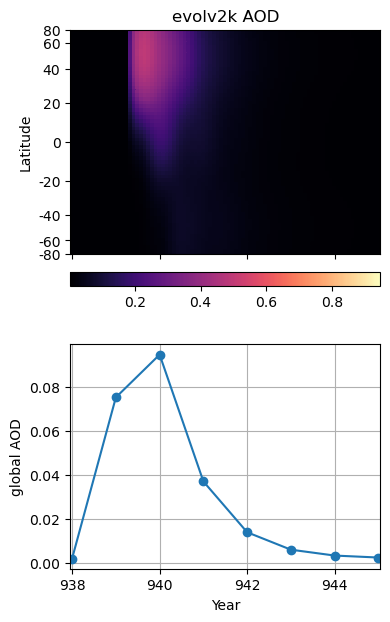

In [29]:
fig = plt.figure(figsize=(4, 7))
# 3 rows, 1 column, .15 space between rows, 8:.3 ratio of top row to bottom row
gs = gridspec.GridSpec(4, 1, hspace=0.15, height_ratios=[5, .3, .5, 5])

# evolv2k AOD
# pcolor
ax0 = fig.add_subplot(gs[0, 0])
pc = ax0.pcolor(t, l,itmp_slice.aod550.data.T, cmap=ax0_sm.cmap, norm=ax0_sm.norm)
ax0.set_title(r'evolv2k AOD')
ax0.set(**ax0_axformatting_d)

# colorbar
ax0c = fig.add_subplot(gs[1, 0])
ax0_cb = plt.colorbar(ax0_sm, cax=ax0c, orientation='horizontal')


# timeseries
ax1 = fig.add_subplot(gs[3, 0])
ax1.sharex(ax0)

ax1.plot(itmp_slice_yr.year,itmp_slice_yr.weighted_aod550,'-o')
ax1.grid(which='both')
ax1.set(**{'ylabel':'global AOD', 'xlabel':'Year'})

ax0.tick_params(labelbottom=False)

## Dashboard
Now let's pull all four plots together into an interactive dashboard. The final dashboard will include a dropdown menu initialized with a list of large volcanic eruptions and a free text field in which a user can request a dashboard for a year not included in the initial list. 

For more details about working with widgets, check out the [widget primer notebook](), but briefly we will need:
- an initial object or set of objects (like a figure with axes)
- a widget (or two)
- one or more function(s) describing what to do when the widget selection has changed (for a plot this often includes instructions about whether to keep or clear actions done by the previous selection and instructions about updating according to the current selection)

##### Non-exhaustive list of volcanic events
The list of volcanic events below will provide a scope of events to investigate. This list is based on N-TREND analysis and meet the following criteria:
1. since 750 CE
2. a global forcing as large as Krakatoa
3. a tropical source
Each event with an identified source has a label in the `erup_names` list, all other events are associated with placeholding question marks. 

In [30]:
erup_yrs = [916,940,1108,1171,1191,1230,1258,1276,1286,1345,1453,1458,1595,1601,1641,1695,1784,1809,1816,1832,1836,1884]
erup_names = ['?','Eldgjá','UE 1108','?','?','UE 1230','Samalas','?',"Quilotoa","El Chichon","?",'Kuwae']
erup_names = erup_names + ["?","Huaynaputina","Parker","UE 1695","Laki","UE 1809","Tambora","?","?","Krakatau"]

n_events = len(erup_yrs)

erup_d = {erup_yrs[ik]:erup_names[ik] for ik in range(len(erup_yrs))}

A few misc parameters

In [31]:
# Set up plotting parameters
before = 2; after = 5; zrange = 40
nc = 21;  fnt='sans-serif'
view = 'global'

For the dashboard, we are specifically interested in the climate response to an event, so it makes sense to subtract the rolling mean from a short period prior. Xarray will once more come to the rescue with its `.rolling().mean()` function combination that specifies how the window should be selected and what should be done with the identified values (in the case of `.mean()`, they should be averaged). 

The function `make_demeaned()` selects data from the specified year and subtracts off the rolling average. 

In [32]:
rolling_mean = lmr_ds_gridded_mean[['hgt500_mean', 'air_mean', 'prate_m']].rolling(time=3, center=False).mean(dim='time')#.isel(time=slice(913,916))

def make_demeaned(erup_yr):
    time_arg1 = np.argwhere(lmr_ds_gridded_mean.time.dt.year.data>erup_yr)[0][0]-1
    demeaned = lmr_ds_gridded_mean[['hgt500_mean', 'air_mean', 'prate_m']].isel(time=time_arg1)-rolling_mean.isel(time=time_arg1-1)
    return demeaned

Sometimes widgets respond promptly, but sometimes they don't. For expediency, we'll pre-calculate de-meaned values for each of the events in the initial list. As part of that pre-compute, we'll build a list of max and min mean air temperature and precipitation rate values which will likely contain the bounding values (or close) that we will want to construct our color scales.

In [33]:
demeaned_d = {}
air_lim = []
prate_lim = []

for erup_yr in erup_yrs:    
    demeaned_d[erup_yr]= make_demeaned(erup_yr)
    air_lim += [demeaned_d[erup_yr]['air_mean'].max().values.ravel()[0], 
                demeaned_d[erup_yr]['air_mean'].min().values.ravel()[0]]

    prate_lim += [demeaned_d[erup_yr]['prate_m'].max().values.ravel()[0], 
                demeaned_d[erup_yr]['prate_m'].min().values.ravel()[0]]


In order to cleanly update the dashboard, each subfigure will need to be cleared, have any axis configuratioon reapplied, and finally be replotted. It is not strictly necessary to split this into two functions, but splitting it into two functions, one that sets things up and another that plots, is a good habit for other widget use cases. 

In [34]:
tick_lat = np.arange(-80,100,20)
sin_ticks = np.sin(tick_lat*np.pi/180)
erup_yrs_array = np.array(erup_yrs)
width = 7
        

# plot the data for the four frames
def plot(val):
    ax0_cmap = plt.get_cmap('magma')
    erup_yr = val
    erup_yrs_array = np.array(erup_yrs)
    
    if erup_yr not in erup_yrs:
        prev_erup_ind = np.argmin(erup_yrs_array<erup_yr)-1
        prev_erup_yr = erup_yrs_array[prev_erup_ind]
        erup_name = erup_d[prev_erup_yr]
        title = 'Year={}, {} years after {} eruption ()'.format(erup_yr, erup_yr-prev_erup_yr, erup_name, prev_erup_yr) 
    else:
        erup_name = erup_d[erup_yr]
        title = 'Year={}, immediate response to {} eruption'.format(erup_yr, erup_name)

    # pcolor
    itmp_slice = vol_ds.sel(time=slice(erup_yr-before, erup_yr+after))
    t, l = np.meshgrid(itmp_slice.time,itmp_slice.lat_rad)
    pc = ax0.pcolor(t, l,itmp_slice.aod550.data.T, cmap=ax0_sm.cmap, norm=ax0_sm.norm)
    ax0.set_title(r'evolv2k AOD',fontname=fnt)
    
    # timeseries
    itmp_slice_yr = vol_ds_year_wm.sel(year=slice(int(erup_yr)-before, int(erup_yr)+after))
    ax1.plot(itmp_slice_yr.year,itmp_slice_yr.weighted_aod550,'-o')
    ax1.grid(which='both')
    
    ax0.tick_params(labelbottom=False)
    
    # maps
    demeaned = demeaned_d[erup_yr]                     
    tas_c, lonc = cutil.add_cyclic_point(demeaned['air_mean'], demeaned['lon'])
    zg_c , _ = cutil.add_cyclic_point(demeaned['hgt500_mean'], demeaned['lon'])                     
    cf2 = ax2.contourf(lonc,demeaned['lat'],tas_c,nc, levels=ax2_levels, 
                       transform=ccrs.PlateCarree(), **cf2_kwargs)
    cf2_lines = ax2.contour(lonc,demeaned['lat'], zg_c, np.linspace(-zrange,zrange,15),
                            colors='k',
                            transform=ccrs.PlateCarree(), linewidths=.5)
    ax2.set_title(r'SAT Anomaly and $Z_{500}$',fontname=fnt)

    pr_c, lonc = cutil.add_cyclic_point(demeaned['prate_m'], demeaned['lon'])
    cf3 = ax3.contourf(lonc,demeaned['lat'],pr_c,nc, transform=ccrs.PlateCarree(), 
                       levels=ax3_levels,**cf3_kwargs)
    ax3.set_title(r'Precipitation Anomaly',fontname=fnt)
    
    fig.suptitle(title,fontsize=13*width/6,fontname=fnt)

# clear and reset the axis configurations
def reset_axes_plot(val):
    ax0.set(**{'ylabel':'Latitude', 
               'ylim':[min(sin_ticks), max(sin_ticks)], 
               'yticks':sin_ticks, 'yticklabels':map(str, tick_lat)})
    
    ax1.set(**{'ylabel':'global AOD'})
    
    ax2.set_global()
    ax2.add_feature(cfeature.COASTLINE, edgecolor='k')

    ax3.set_global()
    ax3.add_feature(cfeature.COASTLINE, edgecolor='k')

    if type(val) == int:
        plot(val)
    else:
        plot(int(val.new))


Here we initialize two widgets: a dropdown initially populated by the list of `erup_yrs`,  a free text box that allows you to enter a year not included in that list and a container to put them both in.

In [35]:
%matplotlib ipympl
# if using jupyter notebook rather than jupyer lab, use %matplotlib notebook

# dropdown with major volcanic events
dropdown = widgets.Dropdown(
    value=erup_yrs[0], 
    options=erup_yrs, 
    description='Eruption', 
    layout={'width': 'initial'}
)

# free text field look at a year outside of dropdown options
year_input = widgets.Text(value='', 
                          description='Enter a year (916-1900 CE):', 
                          style={'description_width':  'initial'},
                          continuous_update=False)

# box to hold the dropdown widget and free text field
options = widgets.HBox([dropdown, year_input], layout=widgets.Layout(
    display='flex', justify_content='space-around', width='70%'))

`update_from_dropdown` updates the plots based on the selection made from the dropdown.

`update_from_freefield` updates the plots according to the year typed into the text field, and adds the year (indicated with an astrisk) to the dropdown.  This extra functionality allows you to view a year not included in the original set, and add it to the working set without needing maintain a mental list of which years came from which source.

In [36]:
def update_from_dropdown(val):
    ax0.cla()
    ax1.cla()    
    ax2.cla()
    ax3.cla()
    
    if type(val.new) == str:
        yr = int(val.new.replace('*', ''))
    else:
        yr = val.new
    
    reset_axes_plot(yr)
    fig.canvas.draw_idle()

def update_from_freefield(val):
    ax0.cla()
    ax1.cla()    
    ax2.cla()
    ax3.cla()
    
    demeaned_d[int(val.new)]=make_demeaned(int(val.new))
    opts = [str(key)+'*' if key not in erup_yrs else str(key) for key in sorted(demeaned_d)]
    dropdown.options = opts
    dropdown.value= int(val.new) if int(val.new) in erup_yrs else str(int(val.new))+'*' 
    
    reset_axes_plot(int(val.new))
    fig.canvas.draw_idle()     

The cell below pulls all the parts together! The four plots are initialized in roughly the same way they were above (the scalar mappables here cover the full range of values included in the precomputed events, rather than being specific to a particular event as they were previously). The primary new information is the setting up the widgets to `observe` behavior. 
For example,
```
dropdown.observe(update_from_dropdown, 'value')
```
sets up the dropdown to pass the selected value to the `update_from_dropdown()` function.

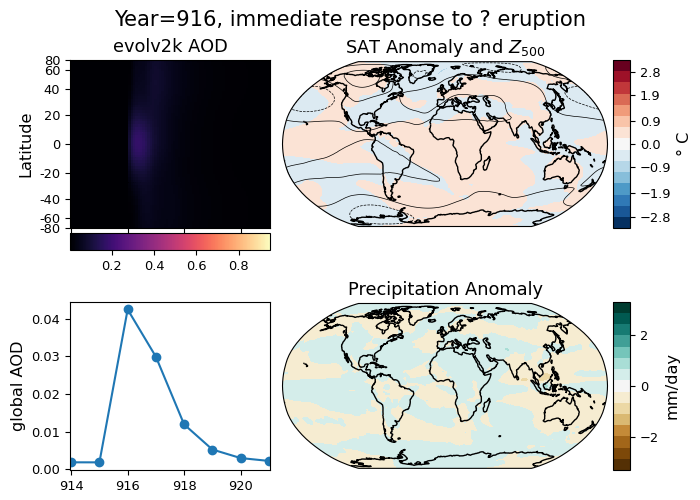

In [37]:
%matplotlib ipympl
# if using jupyter notebook rather than jupyer lab, use %matplotlib notebook
plt.close('all')
width, height = 7, 5

div = 6
plt.rcParams.update({'ytick.labelsize':8*width/div, 'xtick.labelsize':8*width/div, 
                          'axes.titlesize':11*width/div,  'axes.labelsize':10*width/div})

fig = plt.figure(figsize=(width, height))#subplots(3,2,figsize=(12,6))#,sharex=True)
gs = gridspec.GridSpec(4, 5, bottom=.06, top=.88, right=.9,left=.1, wspace=0,hspace=.05,
                       width_ratios=[.8, .05,1.3,.02,.07], height_ratios=[1,.1,.25,1])

# evolv2k AOD
ax0 = fig.add_subplot(gs[0, 0])
ax0c = fig.add_subplot(gs[1, 0])
vol_vlims = [vol_ds.aod550.max().values.ravel()[0], vol_ds.aod550.min().values.ravel()[0]]
ax0_sm = make_scalar_mappable(vol_vlims, 'magma')
ax0_cb = plt.colorbar(ax0_sm,cax=ax0c, orientation='horizontal')

ax1 = fig.add_subplot(gs[3, 0])
ax1.sharex(ax0)
ax1.grid(which='both')

# LMR
# temp                     
ax2 = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson(central_longitude=0))
ax2c = fig.add_subplot(gs[0, 4])
ax2_Li_1 = max(np.abs(air_lim))
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)
cb2 = plt.colorbar(ax2_sm,cax=ax2c, orientation='vertical',label="\xb0 C", 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}

# precip                     
ax3 = fig.add_subplot(gs[3, 2], projection=ccrs.Robinson(central_longitude=0))
ax3c = fig.add_subplot(gs[3, 4])                     
ax3_Li_1 = max(np.abs(prate_lim))
ax3_levels = np.around(np.linspace(-ax3_Li_1, ax3_Li_1, 15), decimals=2)
ax3_sm = make_scalar_mappable([ax3_Li_1, -ax3_Li_1], 'BrBG', 15)
cb3 = plt.colorbar(ax3_sm,cax=ax3c, orientation='vertical',label='mm/day')
cb3.minorticks_off()
cf3_kwargs = {'cmap':ax3_sm.cmap,
             'norm':ax3_sm.norm}  

# initial plot
valinit = 0
reset_axes_plot(erup_yrs[valinit])

# initiate observing by widgets
dropdown.observe(update_from_dropdown, 'value')
year_input.observe(update_from_freefield, 'value')

# display widgets
widgets.VBox([options])


And voila! A dashboard that can be explored via a dropdown! Hopefully this notebook showed that a dashboard is mostly a collection of simpler plots, but there are a few adjustments that can help tie axes together and widgets can make exploring a data set more space-efficient.